In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [3]:
!pip install xlrd

     |████████████████████████████████| 102kB 4.6MB/s ta 0:00:011


In [492]:

lst = [200,201,204,207,210,189,198,210,199,214,193,194,193,200,204,210]
np.var(lst, ddof=0)**0.5


7.0522602759682655

In [469]:
master = pd.DataFrame() # initialize the master dataset

# set a variable "avg_hours" to a number that represents hours that polling stations remained open.
# This varies drastically and is rarely recorded so I am going with 12 hours which seems to be fairly standard across the US
avg_hours = 12

# define our time to vote calculation function
# we take in the row as the first argument because this function is fed into the df.apply() method.
# Then we multiply the first threee terms, passed as column strings, and divide by the 4th. The result is multiplied by 60 to convert the unit to hours.
def calc_timeToVote(row, *args):
#     row = row[ordered_names].astype(float)
    # early out for rows with a "0" in one of the columns
    # This "nan" value indicates that the computation couldn't complete due to insufficient data
    for a in args:
        if row[a] <= 0:
            raise Exception
    
    # EQUATION: 60 * (num_workers * num_stations * hours_open) / num_active_voters
    numerator = float(row[args[0]] * row[args[1]] * row[args[2]])
    denominator = float(row[args[3]])+(10**-8) # add 10^-8 to avoid a zero division
    hours = numerator / denominator
    mins = hours * 60
    return mins

# TESTING CODE ==
tdf = pd.DataFrame({'A':[1,2], "B": [2,6], 'C':[3,1],'D': [3,2]}) # create a test df "tdf" with 4 columns
tdf.apply(lambda r: calc_timeToVote(r, 'A', 'B', 'C', 'D'), axis=1) # pass in our calc_timeToVote() function using a lambda expression in an apply() statement
# Check: (1*2*3 / 3) * 60 == 120; (2*6*1 / 2) * 60 ~= 360
# == 

0    120.000000
1    359.999998
dtype: float64

# 2004 with the UOCAVA survey
# --
There are seperate XLS files for each State's jurisdictions as well as a state level summary.
Within each XLS, our columns of interest are spread across multiple tables. 

Table Population Estimates contains the column "2004 Estimated VAP" (Voting Age Population)

Table Registration contains "Active Registration" by county

Table Ballots Counted contains "Total Ballots Counted"

Table Poll Workers contains " Total Number of Polling Places" and "Total Number of Poll Workers"


In [332]:
# using the state summary file im taking the column with the state names "Unnamed: 1" grabbing the actual state names, 
# "values from index 5 to 60" and applying the strip function

state_summary = pd.read_excel('Data/_elections/2004/StateLevelSummary.xls')
states = state_summary['Unnamed: 1'].iloc[5:60].apply(lambda x: x.strip())
len(list(states)) # This gives us a list of 55 states. Including Puerto Rico, the Virgin Islands, Guam, American Samoa and the District of Columbia

55

In [333]:
# This cell will loop through the list of states created above and read, then clean, each states polling data

# Each state's XLS file contains numerous sheets. These are the ones we will request
desired_sheets = ['Population Estimates', 'Registration', 'Ballots Counted', 'Poll Workers']

# Base relative path from this workbook to the state XLS files
base_path_2004 = 'Data/_elections/2004/State Data Tables 2004 UOCAVA Survey/'

# initialize the final aggregate df to none
master_sheet = None

# begin outer loop
for state in states:
    print('Reading data for "{}"'.format(state))
    state_data = pd.read_excel(base_path_2004 + '/{}_Jurisdictions.xls'.format(state), # provide the absolute path to the XLS file, filling in the state
                           sheet_name=desired_sheets) # Collect the sheets with the columns we want
#     print('Got back "{}" sheets'.format(state_data.keys()))
    # state_data is now a dictionary of dataframes where the keys are the sheet names from the read_excel statement

    # We should clean this table to prepare it for a merge with the other tables.
    standard_columns = ['State', 'County']
    sdf = None # init state df to None
    for sheet in state_data.keys():
#         print('-- Cleaning sheet: {}'.format(sheet))
        df = state_data[sheet]

        
        if sheet == 'Population Estimates':
            # 1. rename the necessary columns
            pop_estimates_naming_dict = {'Unnamed: 1':'State', 'Unnamed: 3':'County','Unnamed: 5':'Est. Citizen VAP'}
            df = df.rename(columns=pop_estimates_naming_dict)
            df = pd.DataFrame(df[list(pop_estimates_naming_dict.values())])
            
#             print(type(df))            
        
        elif sheet == 'Registration':
            # 1. rename the necessary columns
            reg_naming_dict = {'Unnamed: 1':'State', 'Unnamed: 3':'County', "Unnamed: 6":'Active Registrations'}
            df = df.rename(columns=reg_naming_dict)
            df = pd.DataFrame(df[list(reg_naming_dict.values())])
            
            df = df.iloc[5:-4]
            
        elif sheet == 'Ballots Counted':
            ballots_naming_dict = {'Unnamed: 1':"State", 'Unnamed: 3':'County', 'Unnamed: 7':'Ballots Counted'}
            df = df.rename(columns=ballots_naming_dict)
            df = pd.DataFrame(df[list(ballots_naming_dict.values())])
            
            df = df.iloc[5:-4]
            
        elif sheet == 'Poll Workers':
            workers_naming_dict = {'Unnamed: 1':'State', 'Unnamed: 3':'County', 'Unnamed: 5':'Polling Places', 'Unnamed: 6':'Poll Workers'}
            df = df.rename(columns=workers_naming_dict)
            df = pd.DataFrame(df[list(workers_naming_dict.values())])
            
            df = df.iloc[5:-4]
            
        # sdf is the state df. Follow this logic to either add a column, define new or pass when completed
        if sdf is None:
            sdf = df
#             print('-- Assigned State to current value of DF')
        else: # This is true if the current value of "state" is equal to the last value in the State column. ie we are adding a new column for the same state
#             print('-- Merging "{}" into master_sheet.'.format(sheet))
            sdf = pd.merge(sdf, df, on=['State', 'County'])
#             print('-- State DF has "{}" rows and "{}" columns'.format(len(sdf), len(sdf.columns)))

    
    if master_sheet is None:
        master_sheet = sdf
    else:
        print('Appending "{}" rows from "{}" to master_sheet'.format(len(sdf), state))
        master_sheet = master_sheet.append(sdf, ignore_index=True)
    
    
    print('master_sheet has "{}" rows'.format(len(master_sheet))) 

Reading data for "Alabama"
master_sheet has "67" rows
Reading data for "Alaska"
Appending "1" rows from "Alaska" to master_sheet
master_sheet has "68" rows
Reading data for "Arizona"
Appending "15" rows from "Arizona" to master_sheet
master_sheet has "83" rows
Reading data for "Arkansas"
Appending "75" rows from "Arkansas" to master_sheet
master_sheet has "158" rows
Reading data for "California"
Appending "58" rows from "California" to master_sheet
master_sheet has "216" rows
Reading data for "Colorado"
Appending "64" rows from "Colorado" to master_sheet
master_sheet has "280" rows
Reading data for "Connecticut"
Appending "169" rows from "Connecticut" to master_sheet
master_sheet has "449" rows
Reading data for "Delaware"
Appending "3" rows from "Delaware" to master_sheet
master_sheet has "452" rows
Reading data for "District of Columbia"
Appending "1" rows from "District of Columbia" to master_sheet
master_sheet has "453" rows
Reading data for "Florida"
Appending "67" rows from "Flori

In [319]:
# A few final touches after the state aggregation are in order

# I want to add the year to the table 
master_sheet['Year'] = 2004

# Then I want to add a value avg_hours in a column Hours Open. Im assigning the value as the average of other polling hours because the data is not available
master_sheet['Hours Open'] = avg_hours

# Now we will calculate timeToVote = (num_workers * num_locations * hours / active voters) * 60
master_sheet['Time to Vote'] = master_sheet.apply(lambda r: calc_timeToVote(r, ['Polling Places', 'Poll Workers', 'Hours Open', 'Active Registrations']), axis=1)

# after looking over the first version of this file I notice a few problems
# 1. ME didnt record the number of poling places in each county
# 2. MA didnt record the number of poll workers
# 3. MN didnt record either
# 4. WI should be dropped from the table all together
discard_states = ['ME', 'MA', 'MN', 'WI', 'AS', 'GU'] # This is a list of states that we will remove from the DF in the next line
master_sheet = master_sheet.loc[master_sheet['State'].apply(lambda s: s not in discard_states)]

# 5. The " County" string should be removed from all values in the County column
master_sheet['County'] = master_sheet['County'].apply(lambda c: c.replace(' County', ''))

# 6. Guam, and American Somoa didnt record any data
    # So Guam elects one non-voting delegate to the house of representatives and they participate in a presidential straw poll but because their delegate doesn't vote, the election doesn't mean anything
    # The somoans don't vote

# 7. Drop rows where there is no value for time to vote
mask = master_sheet['Time to Vote'].notna()
master_sheet = master_sheet.loc[mask]

In [189]:
master_sheet.loc[master_sheet['Time to Vote'] > 120].sort_values('Time to Vote', ascending=False)
# master_sheet.loc[master_sheet['Time to Vote'] == 0].sort_values('Time to Vote', ascending=False)
# master_sheet

,index,State,County,Est. Citizen VAP,Active Registrations,Ballots Counted,Polling Places,Poll Workers,Year,Hours Open,Time to Vote
174,176,CA,Los Angeles,5312680,4035412,3085582,3581,30381,2004,12,19411.138174
788,800,IL,Chicago city,1774329,1416101,1063860,2109,13846,2004,12,14847.015912
1635,3001,NJ,Bergen,600148,522490,401845,326,29991,2004,12,13472.961243
734,744,IL,Cook,1626583,1378159,1024867,1403,11880,2004,12,8707.776679
190,194,CA,San Diego,1889746,1513358,1145035,1449,8194,2004,12,5648.786553
...,...,...,...,...,...,...,...,...,...,...,...
711,720,ID,Owyhee,7205,4955,3719,10,83,2004,12,120.605449
2245,3915,TX,Kleberg,21866,16132,10142,30,90,2004,12,120.505827
2365,4035,UT,Cache,62931,64675,40335,50,216,2004,12,120.231929
2185,3855,TX,Floyd,5073,4155,2598,11,63,2004,12,120.086643


In [174]:
# save this DF to a file for later use
master_sheet.reset_index().drop('index', axis=1).to_csv('Data/_elections/2004/aggregate_state_data_2004.csv')

# 2018
# --
All of the data we need for this election is in a single EAVS csv file. The Codebook in the same directory is how I made the naming dict.

2943 -- samples have nan values in TTV
3501 -- samples in 2018 dataset
587 -- samples are over 120 mins
116.03 -- is the mean of the distribution


<AxesSubplot:>

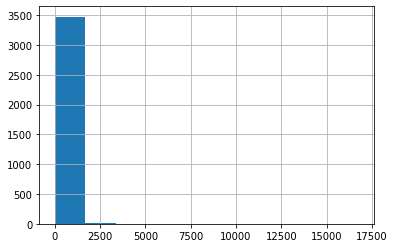

In [447]:
master_2018 = pd.read_csv('Data/_elections/2018/EAVS_2018_for_Public_Release_Updates3.csv', low_memory=False)

# This naming dict comes from the EAVS codebook that is hosted with the dataset
naming_dict_2018 = {'Jurisdiction_Name': 'County', 
                    'State_Abbr':'State', 
                    'State_Full': 'State Name',
                    'A1b':'Active Voters', 
                    'D1a':'Ballots Cast', 
                    'D4a':'Election Day Polling Places',
                    'D5a': 'Early Voting Polling Places',
                    'D6': 'Election Day Poll Workers',
                    'D7': 'Early Voting Poll Workers'}
master_2018 = master_2018.rename(columns=naming_dict_2018)

# Get only the important columns
master_2018 = pd.DataFrame(master_2018[list(naming_dict_2018.values())])

# In this table we have a column for the State Name and its abreviation. lets save that, it might come in handy later
state_codes = master_2018[['State Name', 'State']].set_index('State Name').to_dict()['State']

# Change County values from "ANTIGUA COUNTY" to "Antigua"
master_2018['County'] = master_2018['County'].apply(lambda c: c.replace(' COUNTY', '').title())

# Clean and then aggregate a Election day and early voting data columns
# print('ED Polling Places: ', set(master_2018['Election Day Polling Places']))
# print('ED Poll Workers: ', set(master_2018['Election Day Poll Workers']))

# These 4 columns use 3 different nan values. "Does not apply", "Data not available" and "nan"
# If there was a way to specify the nan value in df.fillna() then this would be much easier but instead we will use these long apply statements
master_2018['Election Day Poll Workers'] = master_2018['Election Day Poll Workers'].astype(str).apply(lambda c: c.replace('Does not apply', '0'))
master_2018['Election Day Poll Workers'] = master_2018['Election Day Poll Workers'].astype(str).apply(lambda c: c.replace('Data not available', '0'))

master_2018['Election Day Polling Places'] = master_2018['Election Day Polling Places'].astype(str).apply(lambda c: c.replace('Does not apply', '0'))
master_2018['Election Day Polling Places'] = master_2018['Election Day Polling Places'].astype(str).apply(lambda c: c.replace('Data not available', '0'))

master_2018['Early Voting Poll Workers'] = master_2018['Early Voting Poll Workers'].astype(str).apply(lambda c: c.replace('Does not apply', '0'))
master_2018['Early Voting Poll Workers']= master_2018['Early Voting Poll Workers'].astype(str).apply(lambda c: c.replace('Data not available', '0'))

master_2018['Early Voting Polling Places']= master_2018['Early Voting Polling Places'].astype(str).apply(lambda c: c.replace('Does not apply', '0'))
master_2018['Early Voting Polling Places']= master_2018['Early Voting Polling Places'].astype(str).apply(lambda c: c.replace('Data not available', '0'))

master_2018['Active Voters']= master_2018['Active Voters'].astype(str).apply(lambda c: c.replace('Does not apply', '0'))
master_2018['Active Voters']= master_2018['Active Voters'].astype(str).apply(lambda c: c.replace('Data not available', '0'))

# Aggregation step
master_2018['Polling Places'] = master_2018['Election Day Polling Places'].astype(float)
master_2018['Poll Workers'] = master_2018['Election Day Poll Workers'].astype(float)

# Drop old columns
master_2018.drop(['Election Day Polling Places', 'Election Day Poll Workers', 'Early Voting Polling Places', 'Early Voting Poll Workers'], axis=1, inplace=True)

# add Hours Open to the DF
master_2018['Hours Open'] = avg_hours

# Calculate Time to Vote
master_2018['Time to Vote'] = master_2018.apply(lambda r: calc_timeToVote(r, ['Poll Workers', 'Polling Places', 'Hours Open', 'Active Voters']), axis=1)
# drop rows that failed the time to vote calculation
print('{} -- samples have nan values in TTV'.format(len(master_2018.loc[master_2018['Time to Vote'] == 'nan'])))
master_2018 = master_2018.loc[master_2018['Time to Vote'] != 'nan']

# Finally, there are 3 counties that reported having over 10,000 polling locations. We want to remove these samples since that is likely an error
master_2018 = master_2018.loc[master_2018['Polling Places'] < 10000]

# Show some summary of the cleaned data
print('{} -- samples in 2018 dataset'.format(len(master_2018)))
print('{} -- samples are over 120 mins'.format(len(master_2018.loc[master_2018['Time to Vote'] >= 120])))
print('{:.2f} -- is the mean of the distribution'.format(np.mean(master_2018['Time to Vote'])))
master_2018['Time to Vote'].hist()

In [449]:
master_2018.loc[master_2018['Polling Places'] < 10000].sort_values('Time to Vote', ascending=False)

,County,State,State Name,Active Voters,Ballots Cast,Polling Places,Poll Workers,Hours Open,Time to Vote
152,Stone,AR,ARKANSAS,6651,4451,2040.0,76.0,12,16783.8
177,Los Angeles,CA,CALIFORNIA,5280658,3023417,4164.0,24651.0,12,13995.5
92,Chicot,AR,ARKANSAS,5140,3607,1893.0,52.0,12,13788.7
166,Del Norte,CA,CALIFORNIA,14150,8439,2898.0,63.0,12,9289.98
113,Hot Spring,AR,ARKANSAS,14958,8794,4110.0,43.0,12,8506.86
...,...,...,...,...,...,...,...,...,...
4103,Sanpete,UT,UTAH,11994,9370,1.0,5.0,12,0.30015
222,Bent,CO,COLORADO,2568,1948,1.0,1.0,12,0.280374
4107,Uintah,UT,UTAH,14537,10519,1.0,4.0,12,0.198115
4109,Wasatch,UT,UTAH,16342,12375,1.0,4.0,12,0.176233


In [328]:
master_2018.to_csv('Data/_elections/2018/aggregate_state_data_2018.csv')

In [456]:
# And now for the demographics for 2018. This comes from the American Community Survey.

dems_2018 = pd.read_csv('Data/_county demographics/2018/ACSDP1Y2018.DP05_data_with_overlays_2021-02-23T170057.csv')

# Update columns
dems_2018.columns = dems_2018.iloc[0]
dems_2018.drop(0, axis=0, inplace=True)

# Turn Geographic area name into State and County columns
dems_2018['County'] = dems_2018['Geographic Area Name'].apply(lambda c: c.split(',')[0].replace(' County', ''))
dems_2018['State'] = dems_2018['Geographic Area Name'].apply(lambda c: c.split(',')[1])

# The ACS provides a lot of data about the accuracy of their estimates which is appreciated but will be ignored.
# Remove all columns that arent the Estimates themselves
non_estimate_headers = ['Margin of Error', 'Percent Estimate', 'Percent Margin of Error'] # We will remove columns that start with these after a split on "!!"
non_estimates = [cn.split('!!')[0] not in non_estimate_headers for cn in dems_2018.columns]
dems_2018 = dems_2018.loc[:, non_estimates]
print('{} -- Estimate columns remain'.format(len(dems_2018.columns)-2))

# And now for column selection
dems_naming_dict = {
    'County':'County', # I am defining these two so they don't get removed when I drop all columns not in the naming dict
    'State': 'State',
    'Estimate!!SEX AND AGE!!Total population': 'Total Pop.',
    'Estimate!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Male': 'VAP Males',
    'Estimate!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Female': 'VAP Females',
    'Estimate!!SEX AND AGE!!Total population!!Under 5 years': 'Pop. Under 5',
    'Estimate!!SEX AND AGE!!Total population!!5 to 9 years': 'Pop. 5 to 9',
    'Estimate!!SEX AND AGE!!Total population!!10 to 14 years': 'Pop. 10 to 14',
    'Estimate!!SEX AND AGE!!Total population!!15 to 19 years': 'Pop. 15 to 19',
    'Estimate!!SEX AND AGE!!Total population!!20 to 24 years': 'Pop. 20 to 24',
    'Estimate!!SEX AND AGE!!Total population!!25 to 34 years': 'Pop. 25 to 34',
   'Estimate!!SEX AND AGE!!Total population!!35 to 44 years': 'Pop. 35 to 44',
   'Estimate!!SEX AND AGE!!Total population!!45 to 54 years': 'Pop. 45 to 54',
   'Estimate!!SEX AND AGE!!Total population!!55 to 59 years': 'Pop. 55 to 59',
   'Estimate!!SEX AND AGE!!Total population!!60 to 64 years': 'Pop. 60 to 64',
   'Estimate!!SEX AND AGE!!Total population!!65 to 74 years': 'Pop. 65 to 74',
   'Estimate!!SEX AND AGE!!Total population!!75 to 84 years': 'Pop. 75 to 84',
   'Estimate!!SEX AND AGE!!Total population!!85 years and over': 'Pop. 85+',
    'Estimate!!Race alone or in combination with one or more other races!!Total population': 'Race Total Pop.',
    'Estimate!!Race alone or in combination with one or more other races!!Total population!!White': 'White',
   'Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American': 'Black',
   'Estimate!!Race alone or in combination with one or more other races!!Total population!!American Indian and Alaska Native': 'Native',
   'Estimate!!Race alone or in combination with one or more other races!!Total population!!Asian': 'Asian',
   'Estimate!!Race alone or in combination with one or more other races!!Total population!!Native Hawaiian and Other Pacific Islander': 'Islander',
   'Estimate!!Race alone or in combination with one or more other races!!Total population!!Some other race': 'Other',    
}
dems_2018.rename(columns=dems_naming_dict, inplace=True)
dems_2018 = pd.DataFrame(dems_2018[list(dems_naming_dict.values())])
print('{} -- Renamed columns remain'.format(len(dems_2018.columns)))

# Resizing population bins. We want to add under 5 and 5-9, 10-14 and 15-19, 55-59 and 60-64
dems_2018['Pop. 0 to 9'] = dems_2018.apply(lambda r: int(r['Pop. Under 5']) + int(r['Pop. 5 to 9']), axis=1)
dems_2018['Pop. 10 to 19'] = dems_2018.apply(lambda r: int(r['Pop. 10 to 14']) + int(r['Pop. 15 to 19']), axis=1)
dems_2018['Pop. 55 to 64'] = dems_2018.apply(lambda r: int(r['Pop. 55 to 59']) + int(r['Pop. 60 to 64']), axis=1)
# Dropping the 5 year bins
dems_2018.drop(['Pop. Under 5', 'Pop. 5 to 9', 'Pop. 10 to 14', 'Pop. 15 to 19', 'Pop. 55 to 59', 'Pop. 60 to 64'], axis=1, inplace=True)

# I am noticing "N" in the Race columns. these should be replaced with "0"s
dems_2018['White'].replace('N', 0, inplace=True)
dems_2018['Black'].replace('N', 0, inplace=True)
dems_2018['Native'].replace('N', 0, inplace=True)
dems_2018['Asian'].replace('N', 0, inplace=True)
dems_2018['Islander'].replace('N', 0, inplace=True)
dems_2018['Other'].replace('N', 0, inplace=True)

# This should replace the state names with postal codes stored in state_codes
dems_2018['State'] = dems_2018['State'].apply(lambda c: state_codes[c.upper().strip()])

91 -- Estimate columns remain
25 -- Renamed columns remain


In [460]:
dems_2018.sort_values('State').to_csv('Data/_county demographics/2018/2018_demographics.csv')

In [462]:
# And now to merge our dfemographic dataset with our polling dataset
dems_2018.merge(master_2018, on=['State', 'County'])#.to_csv('Data/merged demographics and polling data 2018.csv')

,County,State,Total Pop.,VAP Males,VAP Females,Pop. 20 to 24,Pop. 25 to 34,Pop. 35 to 44,Pop. 45 to 54,Pop. 65 to 74,...,Pop. 0 to 9,Pop. 10 to 19,Pop. 55 to 64,State Name,Active Voters,Ballots Cast,Polling Places,Poll Workers,Hours Open,Time to Vote
0,Morgan,AL,119089,42522,45605,7421,13754,14793,15950,12050,...,15064,15228,16415,ALABAMA,75334,39636,39.0,273.0,12,101.758
1,Kings,CA,151366,53103,42321,11790,25319,21572,17598,8751,...,22809,22464,14401,CALIFORNIA,52631,30606,24.0,114.0,12,37.4289
2,Monterey,CA,435594,116568,114453,31653,61898,57220,51007,34393,...,62212,63820,48293,CALIFORNIA,187350,117631,84.0,934.0,12,301.512
3,Nevada,CA,99696,39033,40665,3523,9913,11461,11607,17493,...,8370,10297,16779,CALIFORNIA,68954,54996,8.0,46.0,12,3.84256
4,Shasta,CA,180040,66476,69851,10406,22402,20206,20670,21481,...,21775,20858,26696,CALIFORNIA,101782,70851,84.0,347.0,12,206.191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,Guadalupe,TX,163694,57645,60838,8691,20951,22350,22788,13907,...,22662,24447,19713,TEXAS,87481,55032,34.0,143.0,12,40.016
551,Hidalgo,TX,865939,209843,212957,65787,116806,109162,95222,53503,...,152561,158203,72183,TEXAS,337245,153204,74.0,355.0,12,56.085
552,Midland,TX,172578,54179,55501,10478,30275,24514,17803,10396,...,28217,25173,17918,TEXAS,74109,43127,20.0,99.0,12,19.2365
553,Orange,TX,83572,29621,31777,5520,10779,9740,10262,7618,...,10965,11658,11315,TEXAS,48062,26409,34.0,135.0,12,68.7612
